# Project 3: Representation Learning

## Objectives
Your goal in this project is to get comfortable in implementing k-means, PCA, and neural network. To complete this project, you should understand the following:

* How to use basic math and machine learning modules in python such as numpy
* How to fit a k-means algorithm *from scratch*
* How to perform PCA (principal component analysis) *from scratch* on MNIST dataset
* How to train a neural network *from scratch* on MNIST dataset
* How to evaluate the test results and visualize the outcome of these ML models

## Deliverable
* **Project report/writeup**: A `project3_report_lastname.pdf` file containing your **full solution**, including corresponding plots and results. Follow the `Project 3 - Report (Individual Submission)` link on Gradescope to upload this file. **The report must be self-contained**. 
  - For coding questions, you must include the relevant code snippets and execution results (outputs/plots, if applicable) directly in this PDF. Justifications such as "refer to the source code" are not acceptable. 
  - The report should also include a brief justification of your solution at a high level (e.g., using relevant explanations, equations, or diagrams) and a description of your code structure (e.g., a few sentences per function).



* **Source code**: A `project3_src_lastname1[_lastname2].ipynb` (or `.zip`) file with a working copy of your solutions compiled in a Jupyter notebook. Follow the `Project 3 - Source Code (Group Submission)` link to upload this file.


## Logistics

* You can work in groups of 1-2 students for each course project, and it's your responsibility to find a group (e.g. use Ed Discussion). 
* Every member of a group must complete and submit the project report/writeup individually. While the source code can be the same for all group members, the project report needs to be written independently by each person and, thus, should differ among team member and students more generally.
* One group member need to submit the source code. If you submit as a group, make sure to include your teammate in the group submission. Instructions for team submission can be found [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
* Grades will be provided based on the individual project report. The source code submission will not be graded, but the teaching staff may check the source files if they see the need for reproducing your results when going through your project report. 
* Failure to submit the source code will lead to a deduction of points from your total.

* ⚠️ <span style="color:red"> [For Project 3] </span> **Question Matching**: When uploading your PDF report to Gradescope, you must manually map your response pages to the corresponding questions. <span style="color:red">  Failure to properly match questions will result in point deductions.</span> 


## Task 3A: K-Means (30 points)
K-Means is an unsupervised ML algorithm that segments data into groups based on their similarities. In this part, we will implement k-means from scratch (using only numpy).

### Data Loader
We will use 2-dimensional data in this section. Specifically, the dataset are
2D points $[(x_1, x_2), (x_2, y_2), \dots, (x_n, y_n)]$ that form 5 distinct clusters.

In [51]:
# install seaborn for better visualization
!pip3 install seaborn

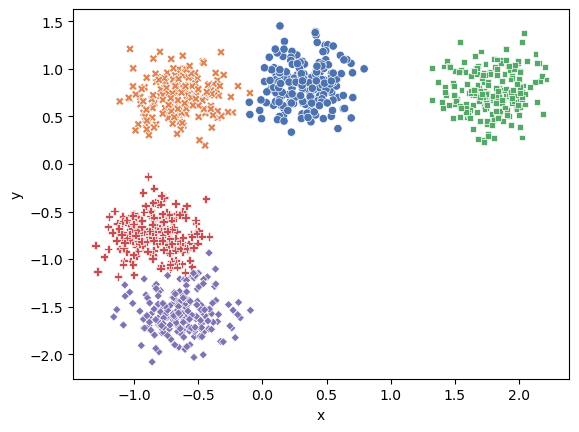

In [5]:
import seaborn as sns
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

num_samples = 1000
num_centers = 5

X_train, true_labels = make_blobs(
    n_samples=num_samples,
    centers=num_centers,
    random_state=80,
)
X_train = StandardScaler().fit_transform(X_train)
sns.scatterplot(
    x=[X[0] for X in X_train],
    y=[X[1] for X in X_train],
    hue=true_labels,
    style=true_labels,
    palette="deep",
    legend=None,
)

plt.xlabel("x")
plt.ylabel("y")
plt.show()

### K-Means Implementation
Now we are implementing the algorithm.

First, we define "similarity" between points. For our dataset, we will be using Euclidean distances.

1. **Implement a helper function**  that has two inputs: dataset, cur_point, and returns the Euclidean distance between cur_point and each point in the dataset.

In [6]:
import numpy as np

def euclidean_dist(cur_point : np.ndarray, dataset : np.ndarray):
    '''
    cur_point has dimensions (m,), dataset has dimensions (n, m), and output will be of size (n,).
    '''
    dists = None
    #! YOUR CODE STARTS HERE
    diff = dataset - cur_point  
    dists = np.sqrt(np.sum(diff**2, axis=1))
    #! YOUR CODE ENDS HERE

    return dists

Now, we implement the actual K-Means algorithm. We first initialize K-Means with two parameters: number of clusters, and max number of iteractions, which you will use in the init function. 

1. **Implent the initialization functions** to accommodate four different seeding strategies: first k, random, max distance, and k-means++.
2. **Implement the fit function** which takes the dataset you created earlier as input. 

Finally, we can assign data points to the closest centroid in the provided predict function.

In [7]:
from enum import Enum
import random
from numpy.random import uniform

class InitializationMethod(Enum):
    FirstK = 1
    Random = 2
    MaxDistance = 3
    KMeansPlusPlus = 4


class KMeans:
    def __init__(self, n_clusters : int = 5, max_iter : int = 1000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None

    def initialize_and_fit(self,
                           initialization_method : InitializationMethod,
                           X_train : np.ndarray):
        # Initialize based on provided method choice.
        if initialization_method == InitializationMethod.FirstK:
            self.centroids = self.__initialize_first_k(X_train)
        elif initialization_method == InitializationMethod.Random:
            self.centroids = self.__initialize_random(X_train)
        elif initialization_method == InitializationMethod.MaxDistance:
            self.centroids = self.__initialize_max_distance(X_train)
        elif initialization_method == InitializationMethod.KMeansPlusPlus:
            self.centroids = self.__initialize_kmeanspp(X_train)

        # Some validation to be sure your methods are at least somewhat behaving.
        assert not self.centroids is None  # The centroids were set.
        assert len(self.centroids) == self.n_clusters  # n_clusters of them were chosen.

        # Fit to the given centroids.
        num_iterations_needed = self.__fit(X_train)
        return num_iterations_needed

    def __initialize_first_k(self, X_train : np.ndarray):
        """
        Initialize the centroids by selecting the first k points in X_train.
        """
        centroids = []

        #! YOUR CODE STARTS HERE
        centroids = np.array(X_train[:self.n_clusters], dtype=float)
        #! YOUR CODE ENDS HERE

        return centroids

    def __initialize_random(self, X_train : np.ndarray):
        """
        Initialize the centroids by selecting k different points uniformly at
        random from X_train.
        """
        centroids = []

        #! YOUR CODE STARTS HERE
        n = X_train.shape[0]
        idxs = np.random.choice(n, size=self.n_clusters, replace=False)
        centroids = np.array(X_train[idxs], dtype=float)
        #! YOUR CODE ENDS HERE

        return centroids

    def __initialize_max_distance(self, X_train : np.ndarray):
        """
        Initialize the centroids by iteratively selecting the furthest point.
        First, a random datapoint is selected as the first centroid, and then
        at each step (until k have been selected) the point in X_train that is
        of maximum distance from any existing cluster center is selected.
        """
        # Pick a random point from train data for first centroid.
        centroids = [random.choice(X_train)]

        # Then choose the remaining points by selecting the point with maximum
        # euclidian distance to any current centroid.
        #
        #! YOUR CODE STARTS HERE
        while len(centroids) < self.n_clusters:
            C = np.array(centroids, dtype=float)
            # distance from each point to each centroid
            dists = np.linalg.norm(X_train[:, None, :] - C[None, :, :], axis=2)
            # for each point, distance to nearest centroid
            min_dists = np.min(dists, axis=1)
            next_idx = int(np.argmax(min_dists))
            centroids.append(X_train[next_idx])
        centroids = np.array(centroids, dtype=float)
        #! YOUR CODE ENDS HERE

        return centroids

    def __initialize_kmeanspp(self, X_train : np.ndarray):
        """
        Initialize the centroids using the "k-means++" method, where a random
        datapoint is selected as the first, then the rest are initialized w/
        probabilities proportional to their distances to the first.
        """
        
        # Pick a random point from train data for first centroid.
        centroids = [random.choice(X_train)]

        # Then choose the remaining points as per kMeans++ algorithm.
        #
        #! YOUR CODE STARTS HERE
        while len(centroids) < self.n_clusters:
            C = np.array(centroids, dtype=float)
            # distances to nearest existing centroid
            dists = np.linalg.norm(X_train[:, None, :] - C[None, :, :], axis=2) 
            min_dists = np.min(dists, axis=1)

            # k-means++ uses probability proportional to squared distance
            probs = min_dists**2
            total = probs.sum()
            if total == 0:
                # all points coincide w/ a centroid; fall back to uniform random
                next_idx = int(np.random.choice(X_train.shape[0]))
            else:
                probs = probs / total
                next_idx = int(np.random.choice(X_train.shape[0], p=probs))
            centroids.append(X_train[next_idx])

        centroids = np.array(centroids, dtype=float)
        #! YOUR CODE ENDS HERE

        return centroids

    def __fit(self, X_train : np.ndarray):
        """
        Iterate, adjusting centroids until converged (new centroids are the same
        as previous centroids) or until passed max_iter.

        Returns the number of iterations needed for the choice of centroids to
        stabilize.
        """
        iteration_count = 0
        prev_centroids = None

        while np.not_equal(self.centroids, prev_centroids).any() and iteration_count < self.max_iter:
            #! YOUR CODE STARTS HERE
            prev_centroids = self.centroids.copy()
            dists = np.linalg.norm(
                X_train[:, None, :] - self.centroids[None, :, :],
                axis=2
            )
            labels = np.argmin(dists, axis=1)
            
            new_centroids = self.centroids.copy()
            for k in range(self.n_clusters):
                cluster_points = X_train[labels == k]
                if len(cluster_points) > 0:
                    new_centroids[k] = np.mean(cluster_points, axis=0)
            
            self.centroids = new_centroids
            #! YOUR CODE ENDS HERE
            iteration_count += 1

        return iteration_count

    def predict(self, X : np.ndarray):
        """
        Assign each data point to the nearest centroid.
        """
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean_dist(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)

        return centroids, centroid_idxs

Now, **test and visualize your k-means algorithm** with various initializations. In the below given code, we separate the different true labels by marker styles (as previously), and we distinguish predicted labels by color.

*You should make sure all centroids ("+" signs) are in different predicted clusters. Hint: initialization is important for k-means, so this may not map to the cluster centroids of true labels for every run.*

The below code will generate 3 charts, each containing 4 sub-plots. 

**Include at least one of them in your report, and comment on your observations**.

- From the visualization results, we observe that the choice of initialization method significantly affects both convergence behavior and final clustering quality. When using First K, the algorithm sometimes converges to suboptimal cluster centers because the first $k$ samples may not be well distributed across the data space. Since the dataset ordering is arbitrary, selecting the first $k$ points can place multiple initial centroids within the same true cluster. This leads to slower convergence and occasionally uneven partitioning of the data.

- The Random initialization generally performs better than First K but still exhibits variability across runs. In some trials, randomly selected centroids are well separated and the algorithm converges quickly to meaningful clusters. However, in other cases, two centroids may be initialized close to one another, which temporarily distorts cluster assignments and may require more iterations to stabilize.

- The Max Distance initialization consistently produces well-separated initial centroids. Since each new centroid is selected as the point farthest from the existing centroids, the initialization naturally spreads across different regions of the dataset. As a result, convergence is typically faster and the final clusters are stable across repeated runs.

- Finally, k-Means++ demonstrates the most reliable and robust behavior. By selecting new centroids with probability proportional to the squared distance from existing centroids, it combines randomness with distance-based spreading. In the visualizations, k-Means++ consistently initializes centroids near distinct true clusters, resulting in clean separation and minimal variation between runs. This aligns with theoretical expectations that k-Means++ reduces the likelihood of poor local minima and improves convergence quality.

- Overall, the experiments confirm that initialization plays a crucial role in k-means performance. Distance-aware methods such as Max Distance and k-Means++ yield more stable and accurate clustering results compared to naive First K or purely Random initialization.

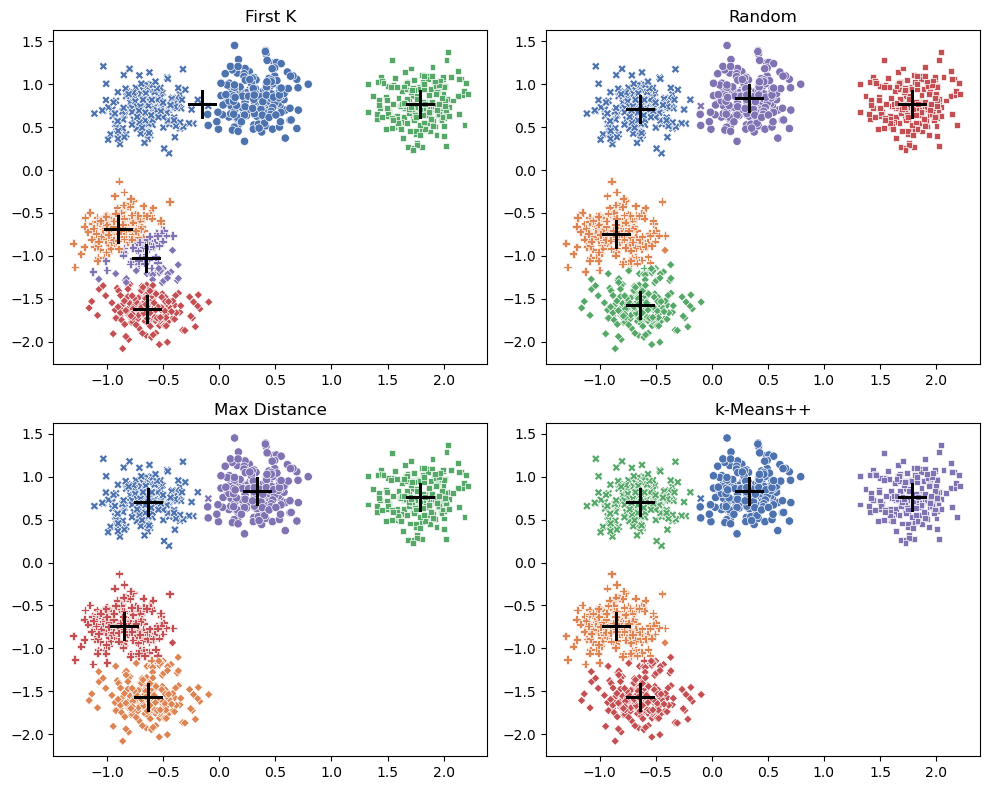

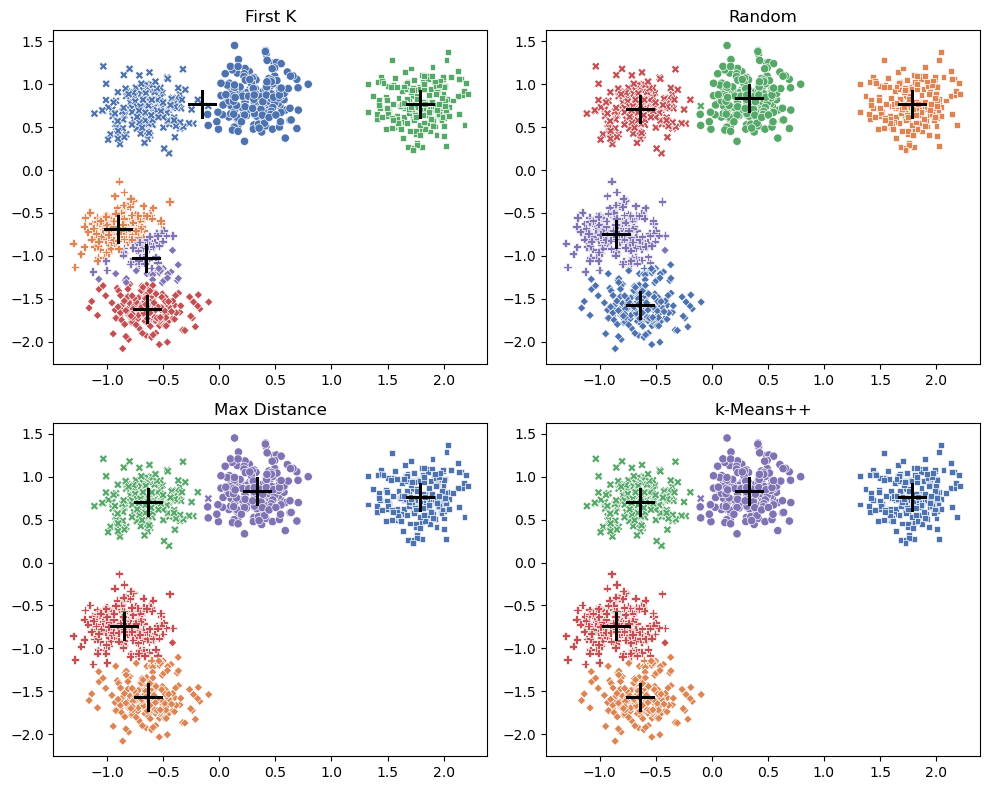

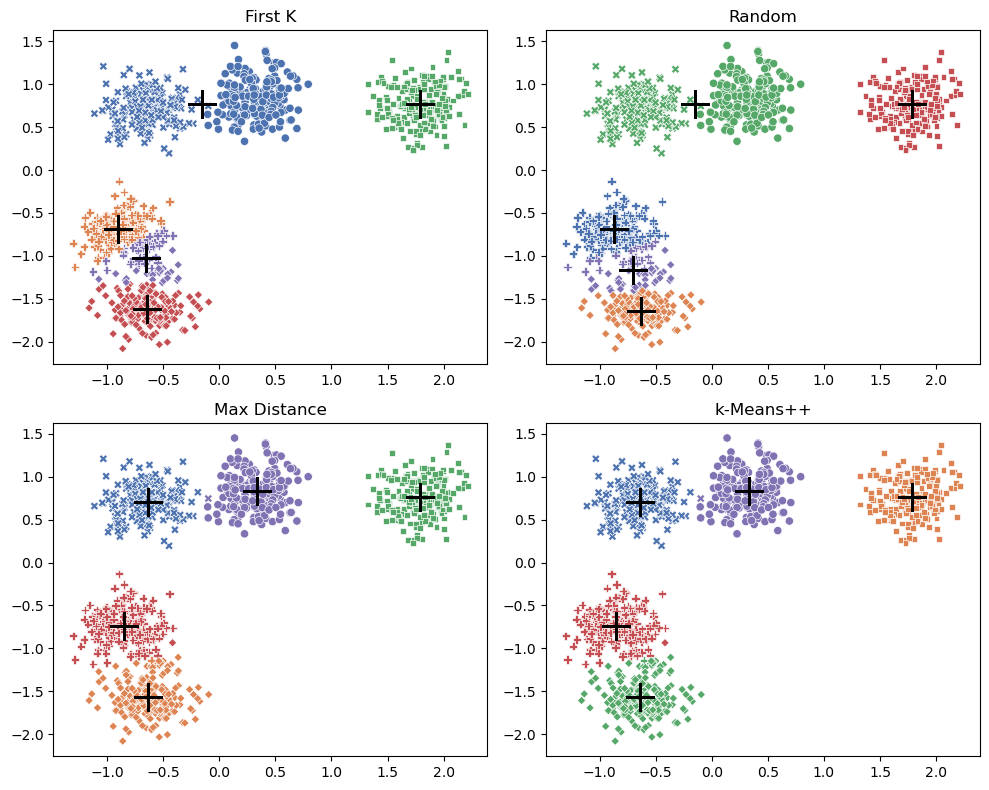

In [86]:
import matplotlib.pyplot as plt
import numpy as np

initialization_methods = [
    (InitializationMethod.FirstK, "First K"),
    (InitializationMethod.Random, "Random"),
    (InitializationMethod.MaxDistance, "Max Distance"),
    (InitializationMethod.KMeansPlusPlus, "k-Means++")
]

def plot_predictions(model : KMeans, X : np.ndarray, y : np.ndarray):
    """Generates a single chart with subplots for multiple model prediction runs."""

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of subplots
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    for i in range(len(initialization_methods)):
        method, name = initialization_methods[i]

        # Initialize with given method.
        model.initialize_and_fit(method, X_train)

        # View results
        class_centers, classification = model.predict(X_train)

        # Plot the ground truths
        sns.scatterplot(
            x=X,
            y=y,
            hue=classification,
            style=true_labels,
            palette="deep",
            legend=None,
            ax=axes[i]
        )
        # Plot the centroids
        axes[i].plot(
            [x for x, _ in class_centers],
            [y for _, y in class_centers],
            '+',
            markersize=20,
            c='black',
        )

        axes[i].set_title(name)

    plt.tight_layout()  # Adjust subplot params for a tight layout
    plt.show()

# Run k-means with each initialization method.
model = KMeans(n_clusters=num_centers)
for _ in range(3):
    plot_predictions(model, [X[0] for X in X_train], [X[1] for X in X_train])

The accuracy of these different methods can be seen above, but that's only the _end result_! As you can see in your code, each of these initialization methods is of varying complexity - so from each initialization state, how many steps does it take to complete initialization? 

**Include this graph in your report, and comment on the results.**

- From the plot, we observe clear differences in the number of iterations required for convergence under different initialization strategies. The First K method consistently converges in approximately the same number of steps (around 12 in this experiment), since it is deterministic and always starts from the same initial centroids. In contrast, Random initialization shows the largest variance in convergence steps, ranging from very few iterations to over 20 in some runs. This variability reflects the instability of purely random starting points, which may begin either close to optimal cluster centers or poorly positioned within the same region. Both Max Distance and k-Means++ converge much faster and more consistently, typically within 3–6 iterations in many runs. Their plots are tighter and centered around lower iteration counts, indicating that distance-aware initialization significantly reduces the number of refinement steps required. Overall, smarter initialization methods not only improve clustering quality but also reduce computational cost by accelerating convergence.


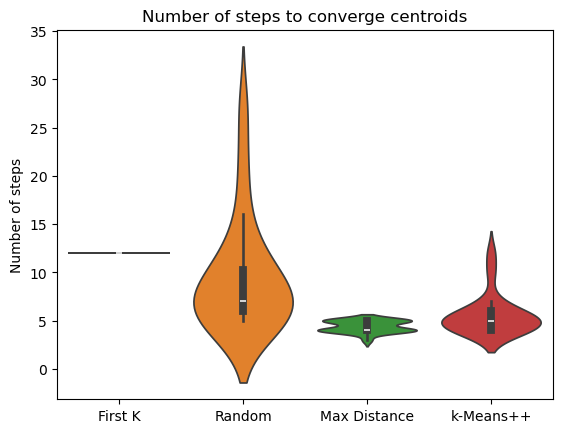

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

iterations = 20

# Run k-means with each initialization method.
model = KMeans(n_clusters=num_centers)
data = [] # Each entry in data will be Tuple<list of steps to converge, name of initialization method>
for method, name in initialization_methods:
    num_steps = []
    for _ in range(iterations):
        num_steps.append(model.initialize_and_fit(method, X_train))
    data.append((num_steps, name))

sns.violinplot([d[0] for d in data])
plt.xticks(np.arange(len(data)), labels=[d[1] for d in data])
plt.title("Number of steps to converge centroids")
plt.ylabel("Number of steps")
plt.show()

#### Questions

In practice, both k-Means++ and Max Distance are used. In what conditions might you prefer one of these methods over another? What are the drawbacks of each method?

*Hint: consider properties of our example. Do datasets in practice always have those properties?*

- In practice, both k-Means++ and Max Distance aim to spread initial centroids across the dataset, but their suitability depends on dataset properties. In well-separated, compact clusters, both methods perform very well because large inter-cluster distances make farthest-point selection meaningful. However, real-world datasets often contain noise, varying cluster densities, or irregular shapes. Max Distance may be overly sensitive to outliers, since extreme points can be selected as centroids, leading to poor cluster representation. In contrast, k-Means++ uses probabilistic sampling proportional to squared distance, which reduces the likelihood of selecting isolated outliers while still encouraging spatial spread. Therefore, k-Means++ is generally preferred in noisy or large-scale datasets due to its theoretical guarantees and robustness. The drawback of k-Means++ is slightly higher initialization cost compared to simple heuristics, while Max Distance can be computationally heavier and unstable when extreme values dominate. Thus, k-Means++ is often the safer default in practical machine learning applications.

## Task 3B: Principal Component Analysis (30 points)

In this problem you will apply PCA for dimensionality reduction to the MNIST dataset.

Note that you must implement PCA directly with Numpy, you are not allowed to use the PCA class from scikit-learn or any other PCA/dimensionality reduction library.

### Load the dataset and visualize some examples

In [8]:
# Download dataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

print('Loading and preprocessing data')
# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, data_home='data')
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.7)

Loading and preprocessing data


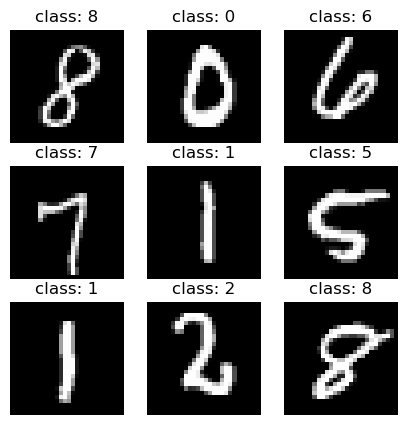

In [9]:
# Plot some random samples from training set
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'class: {y_train[i]}')
    ax.axis('off')

### A simple linear classifier

This class has been implemented for you. You don't need to change code here.

In [10]:
class LinearClassifier:
    """
    Simple linear classifier trained using full-batch gradient descent.
    - Maps n_features -> n_classes logits using a weight matrix W and bias vector b.
    - Applies softmax to the logits to get class probabilities that sum to 1.
    - In prediction, we take the class with the highest probability as our output class.
    """
    def __init__(self, n_features, classes=np.arange(10), eps=1e-4):
        self.classes = classes
        self.W = np.random.rand(n_features, len(classes)) / 30
        self.b = np.random.rand(len(classes)) / 30
        self.eps = eps
    
    def fit(self, X, y):
        assert len(X) == len(y)
        assert set(y) == set(self.classes)

        for i in range(200):
            # Forward pass
            z = X @ self.W + self.b

            # Softmax to convert logits to class probabilities
            exp_z = np.exp(z)
            softmax = exp_z / exp_z.sum(axis=1, keepdims=True)

            # Cross-entropy loss
            n = len(X)
            loss = -np.log(softmax[range(n), y]).sum() / n

            # Backward pass
            dL_dz = softmax
            dL_dz[range(n), y] -= 1
            dL_dz /= n

            dL_dW = X.T @ dL_dz
            dL_db = dL_dz.sum(axis=0)

            # Update weights
            self.W -= self.eps * dL_dW
            self.b -= self.eps * dL_db

            # Print classification accuracy
            if i % 50 == 0:
                predictions = np.argmax(z, axis=1)
                accuracy = (predictions == y).mean()
                print(f'iteration {i}: loss {loss:.4f}, accuracy {accuracy:.4f}')
        predictions = np.argmax(z, axis=1)
        accuracy = (predictions == y).mean()
        print(f'Final iteration {i}: loss {loss:.4f}, accuracy {accuracy:.4f}')
    
    def predict(self, X):
        z = X @ self.W + self.b
        return np.argmax(z, axis=1)


### Baseline

As a baseline, let's report the accuracy of a simple linear classifier trained with full-batch gradient descent. Instead of using all 28 x 28 = 784 pixels as input, we'll uniformly sample 27 pixels from the image and see what our accuracy is.

You should see something around ~57% train accuracy and ~57% test accuracy.

In [11]:
# Subsample every 30 pixels
X_train_subset = X_train[:, ::30]
print(f'Using {X_train_subset.shape[1]} features')

classifier = LinearClassifier(n_features=X_train_subset.shape[1])

# Center the data and store the means
feat_means = X_train_subset.mean(axis=0, keepdims=True)
X_train_subset = X_train_subset - feat_means
classifier.fit(X_train_subset, y_train)

Using 27 features
iteration 0: loss 5.7530, accuracy 0.1160
iteration 50: loss 1.4397, accuracy 0.5428
iteration 100: loss 1.3561, accuracy 0.5632
iteration 150: loss 1.3336, accuracy 0.5700
Final iteration 199: loss 1.3238, accuracy 0.5756


In [12]:
# Evaluate our test accuracy
X_test_subset = X_test[:, ::30]
preds = classifier.predict(X_test_subset - feat_means)
test_acc = (preds == y_test).mean()
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.5727


### PCA for dimensionality reduction in classification

Can we use PCA to choose a more effective set of features?

In [93]:
class PCA:
    def __init__(self, n_components):
        # Number of principal components to keep when we apply PCA
        assert n_components <= 784
        self.n_components = n_components

        self.feature_means = None
        self.U, self.S, self.Vt = None, None, None
        self.U_subset, self.S_subset, self.Vt_subset = None, None, None
    
    def fit(self, X):
        """
        Steps:
        - Center the data (compute, store, and subtract the mean of each feature)
        - Take the SVD of the centered data
        - Truncate the SVD by keeping only the first n_components (singular values)
        """
        #! YOUR CODE STARTS HERE
        # Compute and store mean
        self.feature_means = X.mean(axis=0, keepdims=True)
        
        # Center data
        X_centered = X - self.feature_means
        
        # SVD
        self.U, self.S, self.Vt = np.linalg.svd(X_centered, full_matrices=False)
        
        # Keep only first n_components
        k = self.n_components
        self.U_subset = self.U[:, :k]
        self.S_subset = self.S[:k]
        self.Vt_subset = self.Vt[:k, :]
        return self
        #! YOUR CODE ENDS HERE

    def predict(self, X):
        """
        Steps:
        - Center the data (subtract the mean of each feature, stored in the fit)
        - Project the centered data onto the principal components

        Returns:
        - Projected data of shape (X.shape[0], n_components)
        """
        if self.feature_means is None:
            raise ValueError('fit the PCA model first')

        #! YOUR CODE STARTS HERE
        X_centered = X - self.feature_means
        # Project onto top-k right singular vectors
        X_proj = X_centered @ self.Vt_subset.T
        return X_proj
        #! YOUR CODE ENDS HERE

In [94]:
# Fit PCA
pca = PCA(27)
pca.fit(X_train)

Explained variance ratio with 27 components: 0.3143


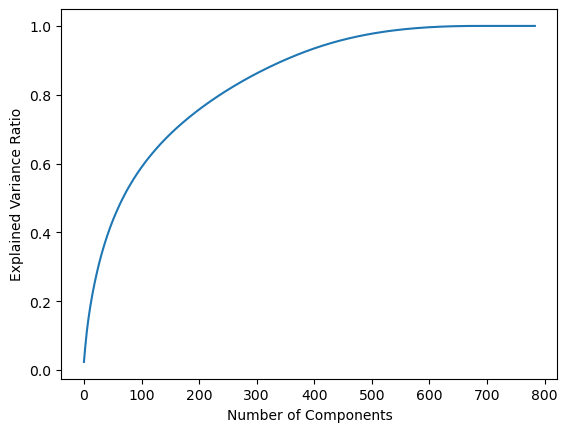

In [95]:
# Plot the explained variance ratio
S = pca.S
explained_var_ratio = S.cumsum() / S.sum()
plt.plot(explained_var_ratio)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")

# Report the truncated feature ratio
print(f'Explained variance ratio with {pca.n_components} components: {explained_var_ratio[pca.n_components]:.4f}')

In [96]:
X_train_subset = pca.predict(X_train)
X_test_subset = pca.predict(X_test)

classifier = LinearClassifier(n_features=27)
classifier.fit(X_train_subset, y_train)

iteration 0: loss 23.4450, accuracy 0.0953
iteration 50: loss 0.6275, accuracy 0.8659
iteration 100: loss 0.4551, accuracy 0.8791
iteration 150: loss 0.4198, accuracy 0.8795
Final iteration 199: loss 0.4143, accuracy 0.8794


Evaluate our test accuracy with PCA. You are expected to achieve a higher accuracy >80%.

In [97]:
preds = classifier.predict(X_test_subset)
test_acc = (preds == y_test).mean()
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.8791


### PCA for visualization
The following block of code will visualize the first 2 principal components. 

**Discuss what you see by comparing the clusters of different digits in the 2D space.**

- In the 2D space formed by the first two principal components, the digits form broad, partially separated clusters rather than perfectly distinct groups. Some classes show relatively compact and more isolated regions (e.g., many “1” samples tend to concentrate in a narrower band and appear more separable), while other digits heavily overlap because their pixel patterns share similar global structure (for example, “3/5/8” and “4/9” often mix in the central area). Overall, PC1 captures a dominant global variation in stroke intensity/shape, spreading certain digits to the extremes, while PC2 captures another major variation (often related to slant/loop vs. straight-stroke structure), pulling other digits upward/downward. The significant overlap indicates that two components preserve only coarse visual features, so fine-grained distinctions between similar digits require higher-dimensional PCs.

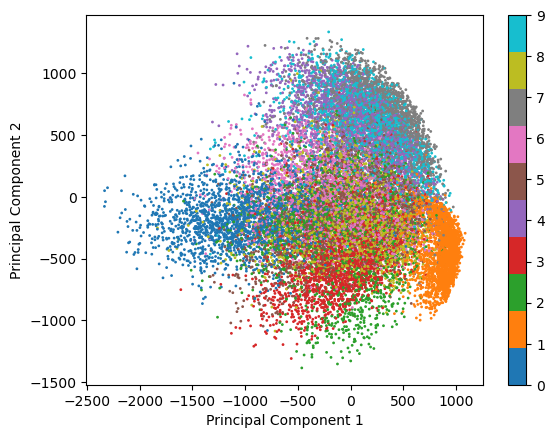

In [98]:
# Plot the first two PCs from the training set
plt.scatter(X_train_subset[:, 0], X_train_subset[:, 1], c=y_train, cmap='tab10', alpha=1.0, s=1)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()

## Task 3C: Neural Network (40 points + 20 bonus points)

Your goal in this exercise is to classify
handwritten digits with neural networks. The training and test units, together with the
structure of a multilayer perceptron class are already provided in the starter code. Your task
is to code up the key lines that complete the **forward** and **backward** propagation functions.


**forward**: Recall that forward propagation corresponds to the prediction algorithm for neural nets. The
intermediate outputs for this method will be cached for backpropagation during the training phase.

**backward**: Backpropagation collects all the gradients necessary for training the neural network, which will be
used as input for the minibatch SGD algorithm GradientDescentOptimizer

In the next, you will need to implement the forward pass and backward pass of the linear layer. For the forward pass, it takes $x_l$ as input and outputs $x_{l+1}$.

$$x_{l+1} = w^\top x_{l} + b_{l}$$
For the backward pass, you will need to compute the backward gradients,



$$\frac{\partial \ell(x, y)}{\partial b}=?$$

$$ \frac{\partial \ell(x, y)}{\partial w}=? $$

$$\frac{\partial \ell(x, y)}{\partial x_{l}}=?$$

where $\ell$ is the loss function. 

### Task 3C.1: Forward and Backward Propogation (20pt)

**Implement the forward and backward pass of the linear layer.** 

Note - wherever you see the None value and #!YOUR CODE STARTS HERE, you are expected to fill in your code there for that variable. You can either overwrite the none value or redefine the same variable after the None assignment

Example:

```python
scores = None 

#!YOUR CODE STARTS HERE
scores = #your implementation here or you can overwrite the None value above

In [13]:
import numpy as np

class Layer(object):
    def __init__(self, shape, activ_func):
        "Implements a layer of a NN."
      
        self.w = np.random.uniform(-np.sqrt(2.0 / shape[0]),
                                   np.sqrt(2.0 / shape[0]),
                                   size=shape)
        self.b = np.zeros((1, shape[1]))

        # The activation function, for example, RELU, tanh, or sigmoid.
        self.activate = activ_func

        # The derivative of the activation function.
        self.d_activate = GRAD_DICT[activ_func]

    def forward(self, inputs):
        """Forward propagate the activation through the layer.
        
        Given the inputs (activation of previous layers),
        compute and save the activation of current layer,
        then return it as output.
        """

        ###################################Description begins#################
        # Forward pass

        # Use the linear and non-linear transformation to
        # compute the activation and cache it in a the field, self.a.

        # Functions you may use:
        # np.dot: numpy function to compute dot product of two matrix.
        # self.activate: the activation function of this layer,
        #                it takes in a matrix of scores (linear transformation)
        #                and compute the activations (non-linear transformation).
        # (plus the common arithmetic functions).

        # For all the numpy functions, use google and numpy manual for
        # more details and examples.        
        
        # Object fields you will use:
        # self.w:
        #     weight matrix, a matrix with shape (H_-1, H).
        #     H_-1 is the number of hidden units in previous layer
        #     H is the number of hidden units in this layer
        # self.b: bias, a matrix/vector with shape (1, H).
        # self.activate: the activation function of this layer.

        # Input:
        # inputs:
        #    a matrix with shape (N, H_-1),
        #    N is the number of data points.
        #    H_-1 is the number of hidden units in previous layer

        ###################################Description ends####################

        # Write code for the following variables according to their description.
        
        # The linear transformation.
        # scores:
        #     weighted sum of inputs plus bias, a matrix of shape (N, H).
        #     N is the number of data points.
        #     H is the number of hidden units in this layer.
        scores = None 
        
        #! YOUR CODE STARTS HERE
        scores = np.dot(inputs, self.w) + self.b
        #! YOUR CODE ENDS HERE
         

        # The non-linear transformation.
        # outputs:
        #     activations of this layer, a matrix of shape (N, H).
        #     N is the number of data points.
        #     H is the number of hidden units in this layer.
        activations = None 
        
        #! YOUR CODE STARTS HERE
        activations = self.activate(scores)
        #! YOUR CODE ENDS HERE

        # Cache the inputs and the activations (to be used by backprop).
        
        self.inputs = inputs
        self.a = activations
        outputs = activations
        return outputs

    def backward(self, d_outputs):
        """Backward propagate the gradient through this layer.
        
        Given the gradient w.r.t the output of this layer
        (d_outputs), compute and save the gradient w.r.t the
        weights (d_w) and bias (d_b) of this layer and
        return the gradient w.r.t the inputs (d_inputs).
        """
        ###################################Description begins#################
        # Backpropagation

        # Compute the derivatives of the loss w.r.t the weights and bias
        # given the derivatives of the loss w.r.t the outputs of this layer
        # using chain rule.

        # Naming convention: use d_var to store the
        # derivative of the loss w.r.t the variable.
        
        # Functions you may use:
        # np.dot (numpy.dot): numpy function to compute dot product of two matrix.
        # np.mean or np.sum (numpy.mean or numpy.sum):
        #     numpy function to compute the mean or sum of a matrix,
        #     use keywords argument 'axis' to compute the mean
        #     or sum along a particular axis, you might also
        #     found 'keepdims' argument useful.
        # self.d_activate:
        #     given the current activation (self.a) as input,
        #     compute the derivative of the activation function,
        #     See d_relu as an example.
        # (plus the common arithmetic functions).
        # np.transpose or m.T (m is an numpy array): transpose a matrix.
        
        
        # Object fields you will use:
        # self.w: weight matrix, a matrix with shape (H_-1, H).
        #         H_-1 is the number of hidden units in previous layer
        #         H is the number of hidden units in this layer
        # self.d_activate: compute derivative of the activation function.
        #                  See d_relu as an example.
        # d_outputs: the derivative of the loss w.r.t the outputs of
        #            this layer, a matrix of shape (N, H). N is the number of
        #            data points and H is the number of hidden units in this layer.
        # self.inputs: inputs to this layer, a matrix with shape (N, H_-1)
        #              N is the number of data points.
        #              H_-1 is the number of hidden units in previous layer.
        # self.a: activation of the hidden units of this layer, a matrix
        #         with shape (N, H)
        #         N is the number of data points.
        #         H is the number of hidden units in this layer.

        ###################################Description ends####################
        
        
        #  Write code for the following variables according to their description.

        # d_scores:
        #     Derivatives of the loss w.r.t the scores (the result from linear transformation).
        #     A matrix of shape (N, H)
        #     N is the number of data points.
        #     H is the number of hidden units in this layer.
        d_scores = None 
        
        #! YOUR CODE STARTS HERE
        # d_outputs is ∂L/∂a (gradient of loss w.r.t. activations)
        # d_scores = d_outputs * ∂a/∂scores
        d_scores = d_outputs * self.d_activate(self.a)
        #! YOUR CODE ENDS HERE

        # self.d_b:
        #     Derivatives of the loss w.r.t the bias, averaged over all data points.
        #     A matrix of shape (1, H)
        #     H is the number of hidden units in this layer.

        self.d_b = None 
        
        #! YOUR CODE STARTS HERE
        # scores = XW + b
        # ∂scores/∂b = 1
        # ∂L/∂b is to sum gradients
        self.d_b = np.sum(d_scores, axis=0, keepdims=True)
        #! YOUR CODE ENDS HERE

        # self.d_w:
        #     Derivatives of the loss w.r.t the weight matrix, averaged over all data points.
        #     A matrix of shape (H_-1, H)
        #     H_-1 is the number of hidden units in previous layer
        #     H is the number of hidden units in this layer.        
        self.d_w = None 
        
        #! YOUR CODE STARTS HERE
        # ∂L/∂W = X^T * d_scores
        self.d_w = np.dot(self.inputs.T, d_scores)
        #! YOUR CODE ENDS HERE

        # d_inputs:
        #     Derivatives of the loss w.r.t the previous layer's activations/outputs.
        #     A matrix of shape (N, H_-1)
        #     N is the number of data points.
        #     H_-1 is the number of hidden units in the previous layer.
        d_inputs = None 
        
        #! YOUR CODE STARTS HERE
        # ∂L/∂X = d_scores * W^T
        d_inputs = np.dot(d_scores, self.w.T)
        #! YOUR CODE ENDS HERE
        
		# Compute the average value of the gradients, since
        # we are minimizing the average loss. 
        self.d_b /= d_scores.shape[0]
        self.d_w /= d_scores.shape[0]
        
        return d_inputs

You have successfully completed task 3A. Please run the code to define the Multi-Layer Perceptron (MLP).

In [14]:
import numpy as np
    
#########################
#  Multilayer Perceptron
#########################

class MLP(object):
    def __init__(self, input_dim, output_dim, sizes, activ_funcs):
        """Multilayer perceptron for multi-class classification.

        The object holds a list of layer objects, each one
        implements a layer in the network, the specification
        of each layer is decided by input_dim, output_dim,
        sizes and activ_funcs. Note that an output layer
        (linear) and loss function (softmax and
        cross-entropy) would be automatically added to the MLP.

        Input: 
          input_dim: dimension of input.
          output_dim: dimension of output (number of labels).
          sizes: a list of integers specifying the number of
            hidden units on each layer.
          activ_funcs: a list of function objects specifying
            the activation function of each layer.

        """
        # Last layer is linear and loss is mean_cross_entropy_softmax
        self.sizes = [input_dim] + sizes[:] + [output_dim]
        self.activ_funcs = activ_funcs[:] + [linear]
        self.shapes = []
        for i in range(len(self.sizes)-1):
            self.shapes.append((self.sizes[i], self.sizes[i+1]))

        self.layers = []
        for i, shape in enumerate(self.shapes):
            self.layers.append(Layer(shape, self.activ_funcs[i]))

    def forwardprop(self, data, labels=None):
        """Forward propagate the activations through the network.

        Iteratively propagate the activations (starting from
        input data) through each layer, and output a
        probability distribution among labels (probs), and
        if labels are given, also compute the loss. 
        """
        inputs = data
        for layer in self.layers:
            outputs = layer.forward(inputs)
            inputs = outputs
            
        probs = softmax(outputs)
        if labels is not None:
            return probs, self.loss(outputs, labels)
        else:
            return probs, None

    def backprop(self, labels):
        """Backward propagate the gradients/derivatives through the network.
        
        Iteratively propagate the gradients/derivatives (starting from
        outputs) through each layer, and save gradients/derivatives of
        each parameter (weights or bias) in the layer.
        """
        d_outputs = self.d_loss(self.layers[-1].a, labels)
        for layer in self.layers[::-1]:
            d_inputs = layer.backward(d_outputs)
            d_outputs = d_inputs

    def loss(self, outputs, labels):
        "Compute the cross entropy softmax loss."
        return mean_cross_entropy_softmax(outputs, labels)

    def d_loss(self, outputs, labels):
        "Compute derivatives of the cross entropy softmax loss w.r.t the outputs."
        return d_mean_cross_entropy_softmax(outputs, labels)
        
    def predict(self, data):
        "Predict the labels of the data."
        probs, _ = self.forwardprop(data)
        return np.argmax(probs, axis=1)


class GradientDescentOptimizer(object):
    def __init__(self, learning_rate, decay_steps=1000,
                 decay_rate=1.0):
        "Gradient descent with staircase exponential decay."
        self.learning_rate = learning_rate
        self.steps = 0.0
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        
    def update(self, model):
        "Update model parameters."
        for layer in model.layers:
            layer.w -= layer.d_w * self.learning_rate
            layer.b -= layer.d_b * self.learning_rate
        self.steps += 1
        if (self.steps + 1) % self.decay_steps == 0:
            self.learning_rate *= self.decay_rate


# Utility functions.
def sigmoid(x): 
    return 1/(1+np.exp(-x))   

def d_sigmoid(a=None, x=None):
    if a is not None:
        return a * (1 - a)
    else:
        return d_sigmoid(a=sigmoid(x))

def relu(x):
    "The rectified linear activation function."
    return np.clip(x, 0.0, None)

def d_relu(a=None, x=None):
    "Compute the derivative of RELU given activation (a) or input (x)."
    if a is not None:    
        d = np.zeros_like(a)
        d[np.where(a > 0.0)] = 1.0
        return d
    else:
        return d_relu(a=relu(x))

def tanh(x):
    "The tanh activation function."
    return np.tanh(x)

def d_tanh(a=None, x=None):
    "The derivative of the tanh function."
    if a is not None:
        return 1 - a ** 2
    else:
        return d_tanh(a=tanh(x))

def linear(x):
    return x

def d_linear(a=None, x=None):
    return 1.0

def softmax(x):
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    f = np.exp(shifted_x)
    p = f / np.sum(f, axis=1, keepdims=True)
    return p
    
def mean_cross_entropy(outputs, labels):
    n = labels.shape[0]
    return - np.sum(labels * np.log(outputs)) / n

def mean_cross_entropy_softmax(logits, labels):
    return mean_cross_entropy(softmax(logits), labels)

def d_mean_cross_entropy_softmax(logits, labels):
    return softmax(logits) - labels


# Mapping from activation functions to its derivatives.
GRAD_DICT = {linear: d_linear, sigmoid: d_sigmoid, tanh: d_tanh, relu: d_relu}


Now that we have defined the MLP, let's prepare the data. 

We will still use the MNIST dataset, but we will preprocess the data differently for the neural network.

We will normalize the pixel values to be between 0 and 1 and use one-hot encoding for the labels.

In [15]:
# Download dataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

print('Loading and preprocessing data')
# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, data_home='data')
X = X / 255.0
y = y.astype(int)

(train_data, test_data, train_labels, test_labels) = train_test_split(X, y, random_state=0, test_size=0.7)

def create_one_hot_labels(labels, dim=10):
    one_hot_labels = np.zeros((labels.shape[0], dim))
    for i in range(labels.shape[0]):
        one_hot_labels[i][labels[i]] = 1
    return one_hot_labels

# Convert labels from integers to one-hot encodings
test_labels = create_one_hot_labels(test_labels)
train_labels = create_one_hot_labels(train_labels)
n_train = train_data.shape[0]

Loading and preprocessing data


### Task 3C.2 Training the Neural Network (10pt)

1. Report the training loss, training accuracy, test loss, and test accuracy for the default network architecture.

    ` MLP(784, 10, [16], [sigmoid])`

In [16]:
# Function to train model and return loss & accuracy
def train_and_eval(model, optimizer=None, n_epochs=25, batch_size=100):    
    if optimizer is None:
        optimizer = GradientDescentOptimizer(0.01)
    train_loss_list = []
    train_accuracy_list = []

    for i in range(n_epochs):
        sum_loss = 0.0
        for j in range((n_train - 1) // batch_size + 1):
            batch_data = train_data[j * batch_size:(j + 1) * batch_size]
            batch_labels = train_labels[j * batch_size:(j + 1) * batch_size]
            
            _, loss = model.forwardprop(batch_data, batch_labels)
            if np.isnan(loss):
                continue
            
            sum_loss += loss
            model.backprop(batch_labels)
            optimizer.update(model)

        train_loss = sum_loss / (j + 1)
        train_accuracy = (np.sum(model.predict(train_data) == np.argmax(train_labels, axis=1)) / 
                          np.float64(train_labels.shape[0]))
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        print('=' * 20 + ('Epoch %d' % i) + '=' * 20)
        print('Train loss %s accuracy %s' % (train_loss, train_accuracy))
    
    _, test_loss = model.forwardprop(test_data, test_labels)
    test_accuracy = (np.sum(model.predict(test_data) == np.argmax(test_labels, axis=1)) / 
                      np.float64(test_labels.shape[0]))
    print('=' * 20 + 'Training finished' + '=' * 20 + '\n')
    print ('Test loss %s accuracy %s\n' %
            (test_loss, test_accuracy))

    return train_loss_list, train_accuracy_list, test_loss, test_accuracy

In [115]:
# Initialize model
print('Initializing neural network')
mlp_gd = MLP(784, 10, [16], [sigmoid])

# For plots, we are tracking a subset of test data points before and after training
selected = np.random.randint(test_data.shape[0], size=100)
true_labels = np.argmax(test_labels[selected], axis=1)
preds_init = mlp_gd.predict(test_data[selected])

print('Start training')
train_loss_gd, train_acc_gd, test_loss_gd, test_acc_gd = train_and_eval(mlp_gd)

preds_trained = mlp_gd.predict(test_data[selected])

Initializing neural network
Start training
====================Epoch 0====================
Train loss 2.2734457932211503 accuracy 0.21585714285714286
====================Epoch 1====================
Train loss 2.1882764051842796 accuracy 0.43961904761904763
====================Epoch 2====================
Train loss 2.1128449554340687 accuracy 0.5501428571428572
====================Epoch 3====================
Train loss 2.0310684731619277 accuracy 0.601
====================Epoch 4====================
Train loss 1.94297073499277 accuracy 0.6318095238095238
====================Epoch 5====================
Train loss 1.8510039204254087 accuracy 0.6538571428571428
====================Epoch 6====================
Train loss 1.7580340046180196 accuracy 0.6741904761904762
====================Epoch 7====================
Train loss 1.666503288710831 accuracy 0.6931904761904762
====================Epoch 8====================
Train loss 1.578180973148045 accuracy 0.7104761904761905
==================

Plot the training loss and accuracy as a function of the number of epochs for debugging.

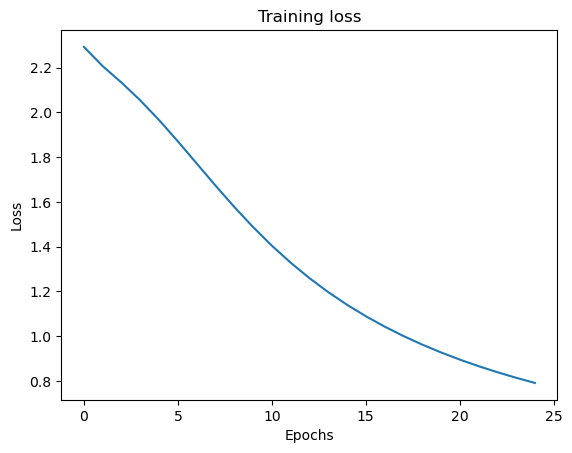

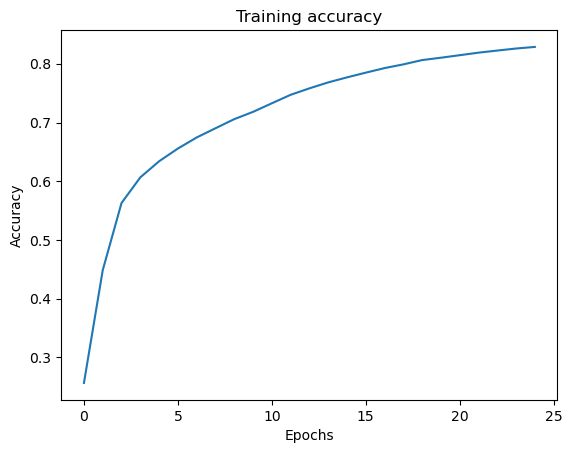

In [104]:
import matplotlib.pyplot as plt

# Plot the training loss and accuracy separately.
n_epochs = len(train_loss_gd)
plt.plot(range(n_epochs), train_loss_gd, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

plt.plot(range(n_epochs), train_acc_gd, label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.show()

## Questions:
1. Briefly comment/discuss your implementation of the `Layer` class 

- In the Layer class, the forward pass implements the linear transformation $XW + b$ followed by a nonlinear activation function. Specifically, the inputs are multiplied by the weight matrix using matrix multiplication and the bias is added to obtain the scores. The activation function is then applied elementwise to introduce nonlinearity. During this process, the layer stores (caches) the inputs and activations so they can be reused in backpropagation without recomputing intermediate values. 

- In the backward pass, the layer applies the chain rule to compute gradients. It first propagates the gradient through the activation function by multiplying the upstream gradient elementwise with the derivative of the activation. Then it computes the bias gradient by summing over the batch dimension, since the same bias is shared across all data points. The weight gradient is computed as $X^\top d\_\text{scores}$, accumulating contributions from all training examples, and the input gradient is computed as $d\_\text{scores} W^\top$ to pass gradients to the previous layer. Finally, since the objective minimizes the average loss over the minibatch, the gradients with respect to weights and bias are divided by the batch size before parameter updates.


1. Report the training loss, training accuracy, test loss, and test accuracy for the default network architecture. Comment on the results.
    
- For the default architecture ` MLP(784, 10, [16], [sigmoid])`, after 25 epochs of training, the final training loss is approximately $0.7919$ with a training accuracy of $0.8368$, and the test loss is approximately $0.7792$ with a test accuracy of $0.8363$. From the plot, the training loss decreases smoothly from about $2.29$ at epoch 0 to about $0.79$ by epoch 24, while the training accuracy rises from roughly $25.7%$ to about $82.9%$, indicating stable convergence. The test performance is very close to the training performance, suggesting that the model does not exhibit significant overfitting. However, the overall accuracy remains in the low 80\% range, which is expected given the relatively small network capacity (a single hidden layer with 16 sigmoid units). A larger or deeper network would likely achieve higher classification accuracy on MNIST.

### Task 3C.3 Visualizing the Predictions and Weights (5pt)

In your solution, include a plot of the test samples using the following code.

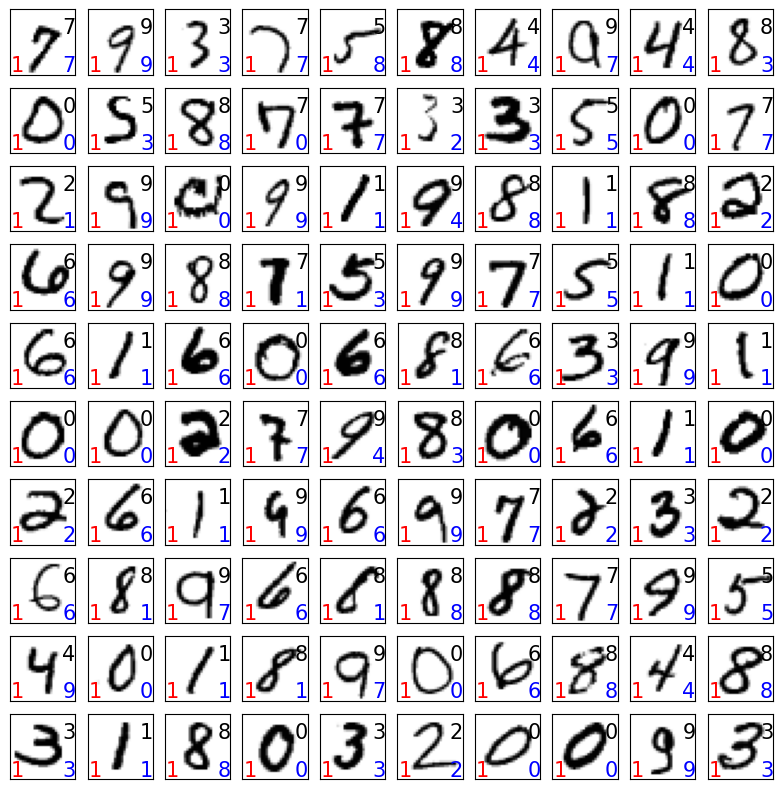

In [74]:
# plot sample test images together with their groundtruth (black), predicted labels before training (red) and predicted labels after training (blue).

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(wspace=0)
for a, image, true_label, pred_init, pred_trained in zip(
        axes.flatten(), test_data[selected],
        true_labels, preds_init, preds_trained):
    a.imshow(image.reshape(28, 28), cmap='gray_r')
    a.text(22, 10, str(true_label), color="black", size=15)
    a.text(22, 26, str(pred_trained), color="blue", size=15)
    a.text(0, 26, str(pred_init), color="red", size=15)

    a.set_xticks(())
    a.set_yticks(())

plt.show()

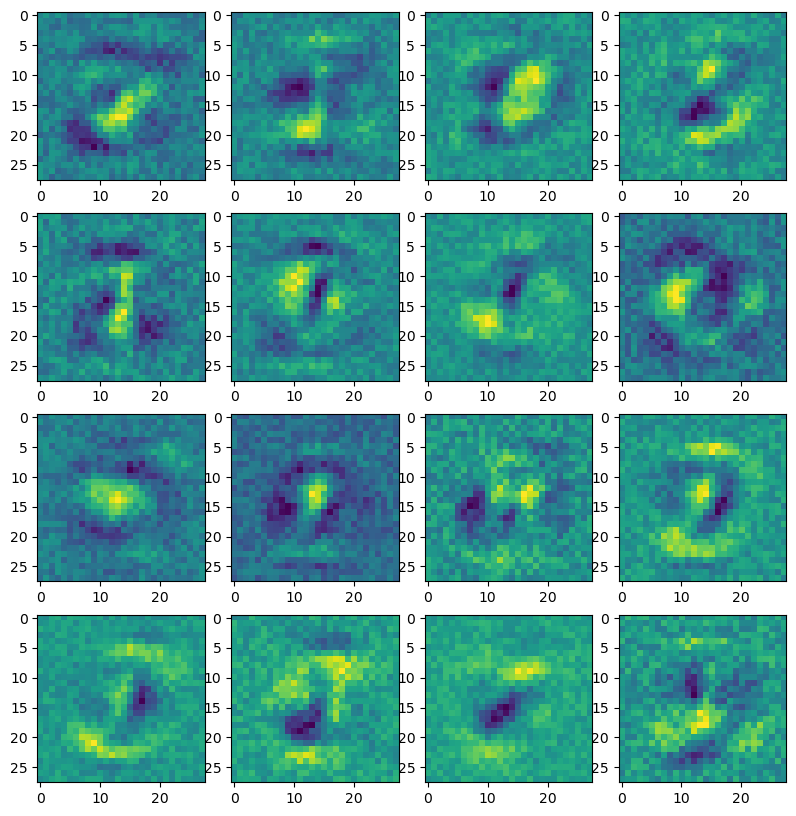

In [75]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.subplots_adjust(wspace=0)
idx = 0
for a in axes.flatten():
    a.imshow(mlp_gd.layers[0].w[:, idx].reshape((28, 28)))
    idx +=1
plt.show()

## Questions:
1. In your report, include a plot of your test-samples. Also include a visualization of the weights of the first layer in the MLP, along with a detailed explanation of the code and a brief summary of any observed patterns and understandings.

- The first figure shows a $10\times 10$ grid of randomly selected test images. Each image is reshaped into a $28\times 28$ grayscale digit and displayed together with three labels, where the ground-truth label is in black, the predicted label before training is in red, and the predicted label after training is in blue. This visualization allows a direct comparison of model performance before and after learning. Before training, many predictions are incorrect and appear almost random. After training, most blue labels match the black ground-truth labels, indicating that the network has successfully learned meaningful patterns from the data. The remaining mistakes typically occur on ambiguous or poorly written digits, where shapes are visually similar.

- The second figure visualizes the learned weights of the first layer. Since the input dimension is $784$ (corresponding to $28\times 28$ pixels) and there are $16$ hidden units, each hidden unit has a weight vector of length $784$. By reshaping each weight vector into a $28\times 28$ image, we can observe what type of spatial pattern each hidden neuron responds to. The visualized weights resemble stroke-like or edge-like patterns, highlighting regions where the neuron assigns stronger positive or negative importance. These patterns often align with common digit structures such as vertical lines, curves, or loops. This suggests that the first layer is learning low-level feature detectors, which are then combined by later layers to perform digit classification.

- Overall, the test-sample visualization demonstrates improved prediction accuracy after training, and the weight visualizations provide insight into how the network internally represents digit features.


### Task 3C.4: Hyperparameter tuning (5pt)

Modify only the network architecture (e.g. number of hidden units, activation functions, etc.) to improve the test accuracy, and provide a summary of your findings.

Theres no strict way to do this but we want to see that you did a meaningful exploration of different architectures and hyperparameters.


In [105]:
# Initialize model
print('Initializing neural network')
model = None 

# instantiate your MLP model and play around with different activations, hidden layer sizes etc. 
#! YOUR CODE STARTS HERE
activations = [sigmoid, tanh, relu]
hidden_layer_sizes = [16, 32, 64]
best_accuracy = 0.0
best_model = None
for activation in activations:
    for hidden_layer_size in hidden_layer_sizes:  
        model = MLP(784, 10, [hidden_layer_size], [activation])
        train_loss_list, train_accuracy_list, test_loss, test_accuracy = train_and_eval(model)
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model
model = best_model
#! YOUR CODE ENDS HERE

# Train the model
train_loss_list, train_accuracy_list, test_loss, test_accuracy = train_and_eval(model)

Initializing neural network
====================Epoch 0====================
Train loss 2.2905751988282432 accuracy 0.3526666666666667
====================Epoch 1====================
Train loss 2.1718431728223377 accuracy 0.44652380952380955
====================Epoch 2====================
Train loss 2.0829149790529042 accuracy 0.5274761904761904
====================Epoch 3====================
Train loss 1.9926204874504205 accuracy 0.5738095238095238
====================Epoch 4====================
Train loss 1.899434809394746 accuracy 0.6096666666666667
====================Epoch 5====================
Train loss 1.8050070016518767 accuracy 0.6381904761904762
====================Epoch 6====================
Train loss 1.7114134590935435 accuracy 0.6591904761904762
====================Epoch 7====================
Train loss 1.6206354521220563 accuracy 0.6768095238095239
====================Epoch 8====================
Train loss 1.5342724117647777 accuracy 0.6941428571428572
==================

In [106]:
# Get the predicted labels
model.predict(test_data[selected])

array([4, 2, 0, 8, 2, 6, 7, 4, 4, 4, 8, 5, 0, 2, 8, 8, 9, 0, 0, 7, 3, 1,
       5, 4, 4, 1, 1, 3, 1, 6, 2, 0, 0, 4, 2, 5, 2, 8, 7, 6, 7, 9, 1, 7,
       5, 2, 4, 0, 6, 1, 6, 0, 0, 1, 4, 8, 8, 8, 4, 6, 8, 3, 0, 6, 7, 1,
       5, 1, 3, 3, 3, 9, 6, 1, 3, 5, 6, 4, 4, 3, 8, 6, 1, 7, 9, 9, 8, 7,
       9, 3, 1, 0, 2, 2, 8, 2, 9, 5, 5, 5])

## Questions:
1. Comment on how changing the network architecture (e.g. number of hidden units, activation functions, etc.) to improve the test accuracy. Provide a summary of your findings.

- I explored different network architectures by varying the activation function (sigmoid, tanh, ReLU) and the number of hidden units (16, 32, 64) while keeping the training procedure unchanged. Overall, increasing the hidden-layer width consistently improved performance because the model gained more capacity to represent digit patterns, and switching from sigmoid to ReLU produced the most noticeable boost in both convergence speed and final accuracy. With smaller models, the test accuracy stayed in the low-to-mid 80\% range (e.g., around 0.82 - 0.87), but larger hidden sizes and especially ReLU achieved substantially better results. The best configuration among my trials reached a test accuracy of 0.9239 with a lower test loss of 0.2685, indicating better generalization. These results suggest that stronger nonlinearities (ReLU) and higher-capacity hidden representations help the MLP learn more discriminative features for MNIST, while smaller sigmoid/tanh networks tend to underfit and plateau earlier.


## (Bonus) Task 3C.5: Adding Momentum Optimization (10 pt)

### Overview
Gradient descent with momentum helps accelerate training by smoothing the update steps. Instead of updating weights solely based on the current gradient, momentum considers past updates to maintain velocity in the optimization path.

### Why Use Momentum?
- Helps navigate **flat regions** and **smoother convergence**.
- Reduces **oscillations** in high-curvature areas.
- Allows for **faster convergence** than standard gradient descent.

### Momentum Update Rule
For each weight $\mathbf{w}$ and bias $b$, we maintain a **velocity term** $\mathbf{v}$ to update parameters as follows:

1. Compute the velocity update:
   $$
   \mathbf{v} = \beta \mathbf{v} - \eta \nabla \mathbf{w}
   $$
   where:
   - $\mathbf{v}$ is the velocity (momentum term),
   - $\beta$ is the momentum coefficient (e.g., 0.9),
   - $\eta$ is the learning rate,
   - $\nabla \mathbf{w}$ is the current gradient.

2. Update the parameters using the velocity:
   $$
   \mathbf{w} = \mathbf{w} + \mathbf{v}
   $$

### Implementation Steps
1. Modify the optimizer to **store velocity** for each parameter.
2. Update parameters using both **past velocity** and **current gradients**.
3. Compare training loss and accuracy **with and without momentum**.

In the next code cell, you will implement the `MomentumOptimizer` class following the above steps.


In [17]:
import numpy as np

class MomentumOptimizer:
    def __init__(
        self, 
        learning_rate: float, 
        momentum: float = 0.9, 
        decay_steps: int = 1000, 
        decay_rate: float = 1.0
    ):
        """
        Stochastic Gradient Descent with Momentum.

        Args:
            learning_rate (float): Initial learning rate.
            momentum (float): Momentum factor (default: 0.9).
            decay_steps (int): Number of steps after which learning rate decays (default: 1000).
            decay_rate (float): Multiplicative factor for learning rate decay (default: 1.0).
        """
        self.learning_rate: float = learning_rate
        self.momentum: float = momentum
        self.steps: int = 0
        self.decay_steps: int = decay_steps
        self.decay_rate: float = decay_rate
        self.velocity_w: dict[int, np.ndarray] = {}  # Velocity for weights
        self.velocity_b: dict[int, np.ndarray] = {}  # Velocity for biases

    def update(self, model) -> None:
        """
        Update model parameters using momentum-based gradient descent.

        Args:
            model: The MLP model with layers containing weights (w), biases (b), 
                   and their corresponding gradients (d_w, d_b).
        """
        for i, layer in enumerate(model.layers):
            if i not in self.velocity_w:
                self.velocity_w[i] = np.zeros_like(layer.w)
                self.velocity_b[i] = np.zeros_like(layer.b)
            
            # Compute velocity updates

            #! YOUR CODE STARTS HERE
            self.velocity_w[i] = self.momentum * self.velocity_w[i] - self.learning_rate * layer.d_w
            self.velocity_b[i] = self.momentum * self.velocity_b[i] - self.learning_rate * layer.d_b
            #! YOUR CODE ENDS HERE

            # Apply updates to parameters - should look like:
            # layer.w += your code 
            # layer.b += your code

            #! YOUR CODE STARTS HERE
            layer.w += self.velocity_w[i]
            layer.b += self.velocity_b[i]
            #! YOUR CODE ENDS HERE
        
        # Apply learning rate decay
        self.steps += 1
        if self.steps % self.decay_steps == 0:
            self.learning_rate *= self.decay_rate

In the next code cell, you will initialize new models, and use the function `train_model(model, optimizer)` to run training with your optimizers.

In [18]:
# Train with both optimizers
print("Gradient Descent")
mlp_gd = MLP(784, 10, [16], [sigmoid])
loss_gd, acc_gd, test_loss_gd, test_acc_gd = train_and_eval(mlp_gd, GradientDescentOptimizer(0.01))

print("Gradient Descent with Momentum")
mlp_mo = MLP(784, 10, [16], [sigmoid])
loss_mo, acc_mo, test_loss_mo, test_acc_mo = train_and_eval(mlp_mo, MomentumOptimizer(0.01, 0.95))

Gradient Descent
====================Epoch 0====================
Train loss 2.284519675221523 accuracy 0.3443809523809524
====================Epoch 1====================
Train loss 2.185435771742065 accuracy 0.5846666666666667
====================Epoch 2====================
Train loss 2.1019491360336096 accuracy 0.571047619047619
====================Epoch 3====================
Train loss 2.01586266148904 accuracy 0.5807142857142857
====================Epoch 4====================
Train loss 1.9259193720574386 accuracy 0.5998571428571429
====================Epoch 5====================
Train loss 1.8336203325225067 accuracy 0.6191428571428571
====================Epoch 6====================
Train loss 1.7410121949775137 accuracy 0.6376190476190476
====================Epoch 7====================
Train loss 1.6500983616779346 accuracy 0.6565238095238095
====================Epoch 8====================
Train loss 1.562553395001534 accuracy 0.6745238095238095
====================Epoch 9========

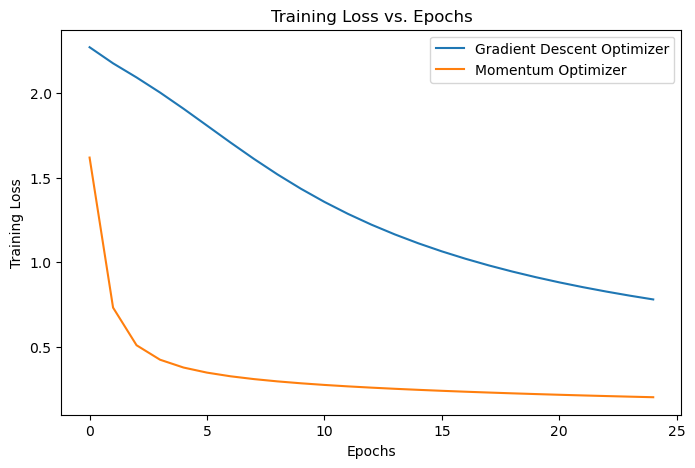

Test Accuracy (Gradient Descent Optimizer): 0.8401
Test Accuracy (Momentum Optimizer): 0.9272


In [118]:
# Plot training loss over epochs
import matplotlib.pyplot as plt

name_gd, name_mo = "Gradient Descent Optimizer", "Momentum Optimizer"
plt.figure(figsize=(8,5))
plt.plot(loss_gd, label=name_gd)
plt.plot(loss_mo, label=name_mo)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.show()

# Print final test accuracy
print(f"Test Accuracy ({name_gd}): {test_acc_gd:.4f}")
print(f"Test Accuracy ({name_mo}): {test_acc_mo:.4f}")

### Questions:

Tune the parameters (like earlier, test a few and keep track of the ones you tested) then answer the following questions:

1. Which optimizer converges faster? Justify your answer based on the training loss curves.

- With the same learning rate $\eta=0.01$, the Momentum Optimizer converges much faster than plain gradient descent AS its training loss drops sharply in the first few epochs (about $1.62 \rightarrow 0.73$ from epoch 0 to 1, and below $\approx 0.30$ by around epoch 8), while gradient descent decreases slowly and remains relatively high over the same period (about $2.27 \rightarrow 2.18$ from epoch 0 to 1, and still above $\approx 1.5$ near epoch 8). This is also clear from the loss curves, where the momentum curve falls steeply early and then gradually flattens, whereas the gradient descent curve declines steadily but much more slowly across all epochs.

2. Does momentum improve test accuracy? Why or why not?

- Yes, momentum improves test accuracy in this experiment. Specifically, the Gradient Descent Optimizer achieves test accuracy $\approx 0.8401$, while the Momentum Optimizer reaches $\approx 0.9272$. This improvement happens because momentum helps the model move through the loss surface more effectively. By reducing back-and-forth movements and helping the model move past flat or slow regions, it reaches a lower training loss and finds a better solution within the same number of epochs. 

3. In what situations would momentum be more beneficial?

- Momentum is more helpful when the loss surface is uneven, such as when it is steep in one direction and flat in another, or when the gradients change a lot from batch to batch. It is also useful when training slows down in flat areas or near saddle points, where regular gradient descent makes very small updates. In these cases, momentum keeps the updates moving in a consistent direction and reduces repeated back-and-forth steps, leading to faster and more stable training, especially for deeper models or more difficult tasks.

## (Bonus) Task 3C.6: Compare MLP to CNN (10pt)

Complete an implmentation of convolutional neural network below. You will need to import/install pytorch 

You can follow this tutorial (or simply pip install torch):
https://pytorch.org/get-started/locally/


In [3]:
# install pytorch for our models
!pip3 install torch

Warning: this might take a while to run on CPU. 

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Assume these variables are already defined:
#   train_data: NumPy array of shape (N_train, 784) with values in [0, 1]
#   test_data:  NumPy array of shape (N_test, 784) with values in [0, 1]
#   train_labels: one-hot encoded labels (shape: (N_train, 10))
#   test_labels:  one-hot encoded labels (shape: (N_test, 10))

# Convert one-hot encoded labels to integer labels
train_labels_int = np.argmax(train_labels, axis=1)
test_labels_int  = np.argmax(test_labels, axis=1)

# Reshape the data from (N, 784) to (N, 1, 28, 28)
train_data_tensor = torch.from_numpy(train_data.reshape(-1, 1, 28, 28)).float()
test_data_tensor  = torch.from_numpy(test_data.reshape(-1, 1, 28, 28)).float()

# Convert labels to PyTorch tensors
train_labels_tensor = torch.from_numpy(train_labels_int).long()
test_labels_tensor  = torch.from_numpy(test_labels_int).long()

# Create DataLoaders for training and testing
batch_size = 64
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define a simple CNN model for MNIST.
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First convolutional block: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # TODO: Adjust parameters if needed
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block: Conv -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # TODO: Adjust parameters if needed
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # After two pooling layers, the 28x28 image becomes 7x7 feature maps.
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # TODO: Ensure dimensions match
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = self.fc2(self.relu3(self.fc1(x)))
        return x


# Instantiate the CNN, define loss and optimizer. You can read pytorch documentation to understand these components.
#! YOUR CODE STARTS HERE
cnn_model = CNNModel()
lossfunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
#! YOUR CODE ENDS HERE


# Training Loop
num_epochs = 5
cnn_model.train()  # Set the model to training mode
print("Training CNN model...")

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()         # Clear the gradients

        #next, you need to implement the training step including forward pass, loss computation, backward pass, and parameter update.
        # 1 start with first getting model ouptputs by passing images through cnn_model
        # 2 next you will need to use your lossfunc 
        # 3 research how to do a backward pass in pytorch (hint: it is very simple!)
        # 4 finally, you will need to update the model parameters using your optimizer (hint: also very simple!)

        #! YOUR CODE STARTS HERE
        outputs = cnn_model(images)          # 1) forward pass
        loss = lossfunc(outputs, labels)     # 2) compute loss
        loss.backward()                      # 3) backward pass
        optimizer.step()                     # 4) update parameters
        #! YOUR CODE ENDS HERE
        
        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0

print("CNN training finished!")
cnn_model.eval()  # Set the model to evaluation mode


# Evaluate the CNN on the test set.
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy of CNN: {100 * correct / total:.2f}%")


Training CNN model...
Epoch [1/5], Step [100/329], Loss: 0.7517
Epoch [1/5], Step [200/329], Loss: 0.2290
Epoch [1/5], Step [300/329], Loss: 0.1589
Epoch [2/5], Step [100/329], Loss: 0.1015
Epoch [2/5], Step [200/329], Loss: 0.0828
Epoch [2/5], Step [300/329], Loss: 0.0786
Epoch [3/5], Step [100/329], Loss: 0.0517
Epoch [3/5], Step [200/329], Loss: 0.0644
Epoch [3/5], Step [300/329], Loss: 0.0631
Epoch [4/5], Step [100/329], Loss: 0.0378
Epoch [4/5], Step [200/329], Loss: 0.0427
Epoch [4/5], Step [300/329], Loss: 0.0439
Epoch [5/5], Step [100/329], Loss: 0.0337
Epoch [5/5], Step [200/329], Loss: 0.0309
Epoch [5/5], Step [300/329], Loss: 0.0370
CNN training finished!
Test Accuracy of CNN: 98.36%


3. Play around with drawing your own numbers and compare. When you run the code, expect a small window to pop up, with `Predict` and `Clear` buttons. After you finish one prediction by drawing and hitting `Predict`, click `Clear` to draw another. 

**Which model is better? Why do you think that is?**

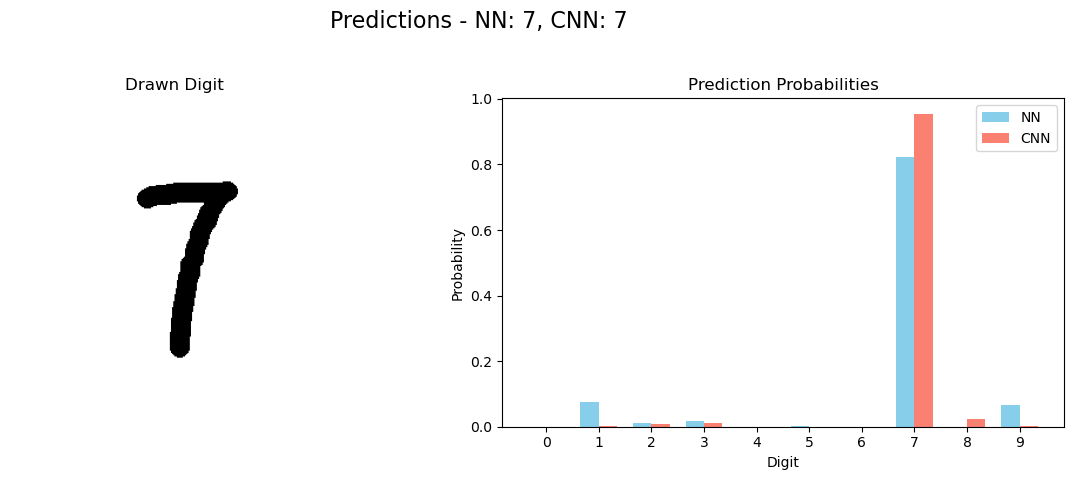

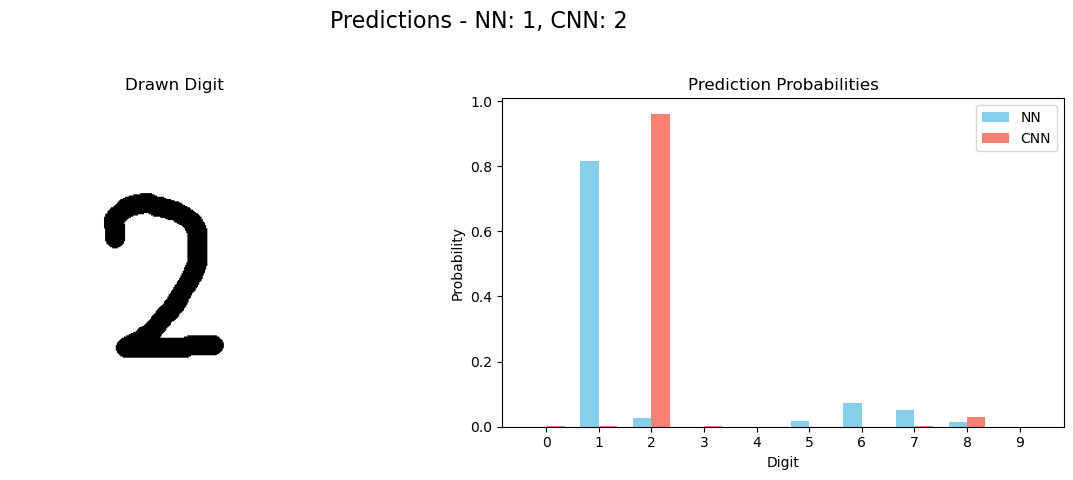

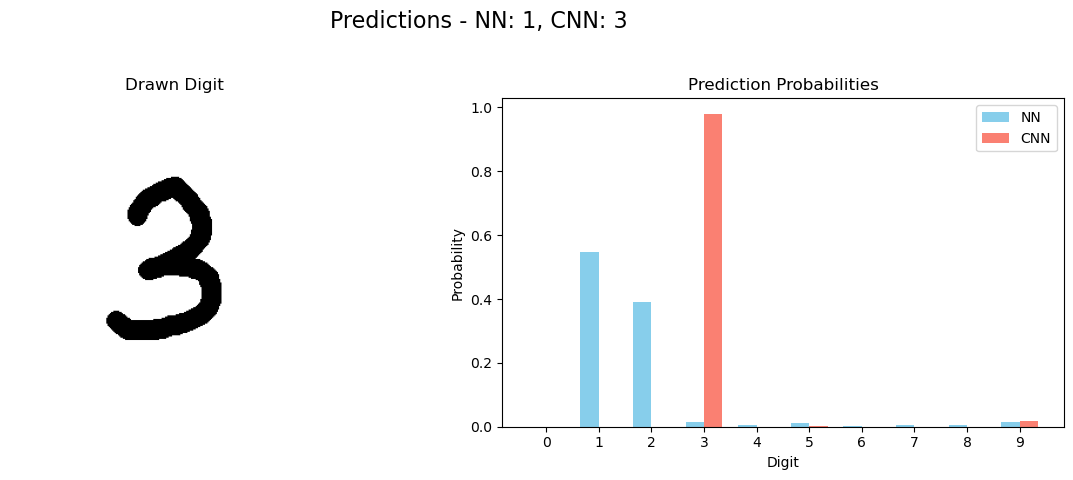

In [32]:
import tkinter as tk
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps
import torch

class DigitDrawer:
    def __init__(self, master, nn_model, cnn_model):
        self.master = master
        self.master.title("Digit Recognition")

        self.canvas_width = 280
        self.canvas_height = 280
        self.canvas = tk.Canvas(master, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.pack(padx=10, pady=10)

        # Frame for buttons
        button_frame = tk.Frame(master)
        button_frame.pack(pady=5)
        
        self.button_predict = tk.Button(button_frame, text="Predict", command=self.predict)
        self.button_predict.pack(side=tk.LEFT, padx=5)

        self.button_clear = tk.Button(button_frame, text="Clear", command=self.clear)
        self.button_clear.pack(side=tk.LEFT, padx=5)

        # Create a high-res image for smoother drawing.
        # We later downsample to 28x28 for the model.
        self.image = Image.new("L", (self.canvas_width, self.canvas_height), 255)
        self.draw = ImageDraw.Draw(self.image)

        self.canvas.bind("<B1-Motion>", self.paint)

        self.nn_model = nn_model
        self.cnn_model = cnn_model
        
    def softmax(x):
        # x is assumed to be a NumPy array
        shifted_x = x - np.max(x, axis=1, keepdims=True)  
        exp_x = np.exp(shifted_x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


    def paint(self, event):
        """Draw on both the canvas and the high-res PIL image."""
        # Define the brush radius
        radius = 8  
        x, y = event.x, event.y
        x1, y1 = x - radius, y - radius
        x2, y2 = x + radius, y + radius

        # Draw on the Tkinter canvas (for display)
        self.canvas.create_oval(x1, y1, x2, y2, fill="black", outline="black")
        # Draw on the high resolution PIL image (for prediction)
        self.draw.ellipse([x1, y1, x2, y2], fill="black")

    def preprocess_image(self):
        """
        Downsample the high-res image (280x280) to 28x28.
        Then normalize the pixel values to [0,1].
        """
        img_resized = self.image.resize((28, 28))
        img_inverted = ImageOps.invert(img_resized) # Invert colors: model expects black background
        img_array = np.array(img_inverted).reshape(1, 1, 28, 28) / 255.0 # Convert image to numpy array and normalize
        return img_array

    def predict(self):
        """Predict the digit using both the NN and CNN models and display the results."""
        img_array = self.preprocess_image()

        # --- NN Prediction ---
        # Use the NN's forward propagation method to get full probabilities.
        nn_probs, _ = self.nn_model.forwardprop(img_array.reshape(1, -1))
        nn_probs = nn_probs[0]  # probabilities for the single sample
        nn_prediction = np.argmax(nn_probs)

        # --- CNN Prediction ---
        self.cnn_model.eval()
        with torch.no_grad():
            img_tensor = torch.tensor(img_array, dtype=torch.float32)
            cnn_output = self.cnn_model(img_tensor)
            cnn_probs = torch.nn.functional.softmax(cnn_output, dim=1).numpy()[0]
            cnn_prediction = np.argmax(cnn_probs)

        # Create a figure to display the drawn image and the prediction probabilities
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Left subplot: the high-res drawn digit (before downsampling)
        axes[0].imshow(self.image, cmap='gray')
        axes[0].set_title("Drawn Digit")
        axes[0].axis('off')

        # Right subplot: a bar chart comparing prediction probabilities
        digits = np.arange(10)
        bar_width = 0.35
        axes[1].bar(digits - bar_width/2, nn_probs, bar_width, label='NN', color='skyblue')
        axes[1].bar(digits + bar_width/2, cnn_probs, bar_width, label='CNN', color='salmon')
        axes[1].set_xticks(digits)
        axes[1].set_xlabel("Digit")
        axes[1].set_ylabel("Probability")
        axes[1].set_title("Prediction Probabilities")
        axes[1].legend()

        plt.suptitle(f"Predictions - NN: {nn_prediction}, CNN: {cnn_prediction}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def clear(self):
        """Clear the canvas and reset the high-res image."""
        self.canvas.delete("all")
        self.image = Image.new("L", (self.canvas_width, self.canvas_height), 255)
        self.draw = ImageDraw.Draw(self.image)

# --------------------------
# Launch the Graphical User Interface
# --------------------------
# Ensure that 'model' (the NN) and 'cnn_model' (the CNN) are loaded before this code runs.
root = tk.Tk()
app = DigitDrawer(root, mlp_mo, cnn_model)
root.mainloop()


### Questions:

Tune the parameters (like earlier, test a few and keep track of the ones you tested) then answer the following questions:

1. Briefly explain your code for above (CNN implementation, training loop, etc.).

- I created the CNNModel with two convolution layers followed by ReLU and max pooling, then flattened the feature maps and passed them through two fully connected layers to produce the final 10-class output. I instantiated the model, chose CrossEntropyLoss as the loss function, and used the Adam optimizer with a learning rate of 0.001. In the training loop, I implemented the key steps, including performing the forward pass (outputs = cnn_model(images)), computing the loss, calling loss.backward() to compute gradients, and using optimizer.step() to update the model parameters. These steps allow the CNN to learn from the training data and achieve high accuracy on the test set.

2. Play around with drawing your own numbers and compare. Which model is better? Why do you think that is?

- Based on the figures, the CNN performs better overall. For the drawn digit 7, both the NN and CNN correctly predict 7, but the CNN assigns a higher probability to the correct class, showing more confidence. For the drawn digit 2, the NN predicts 1 while the CNN correctly predicts 2 with a very high probability, which shows that the CNN better captures the shape of the digit. Similarly, for the drawn digit 3, the NN predicts 1 again, while the CNN correctly predicts 3 with near-certain probability. These examples show that the CNN is more accurate and more confident, especially when the handwritten digit is slightly different from the training examples. This is likely because the CNN uses convolution and pooling layers that learn local stroke patterns and spatial structure, while the NN treats the image as a flat vector and cannot use the 2D structure as effectively.

